# Import the important libraries

In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Load the dataset

In [120]:
file_path = 'D:Downloads/iiot_30min_norm.csv'
df = pd.read_csv(file_path)

# Feature Engineering: Create lag features and rolling statistics

In [123]:
df['FM1_rolling_mean'] = df['FM1'].rolling(window=3).mean()
df['FM1_lag_1'] = df['FM1'].shift(1)
df['FM1_lag_2'] = df['FM1'].shift(2)
df['hour'] = pd.to_datetime(df['TIME']).dt.hour
df['day'] = pd.to_datetime(df['TIME']).dt.day

# Create a new target variable combining FM1 and PE1

In [126]:
failure_threshold_fm1 = df['FM1'].quantile(0.05)
failure_threshold_pe1 = df['PE1'].quantile(0.05)

# Define failure if either FM1 or PE1 drops below their respective thresholds

In [129]:
df['new_target'] = (
    (df['FM1'].rolling(window=5).min() < failure_threshold_fm1) |
    (df['PE1'].rolling(window=5).min() < failure_threshold_pe1)
).astype(int)

# Shift the new target for predictive maintenance (e.g., predicting failures ahead of time)

In [132]:
df['new_target'] = df['new_target'].shift(-5).fillna(0).astype(int)

# Drop rows with NaN values

In [135]:
df = df.dropna()

# Define features and the new target

In [138]:
X = df[['FM1', 'FM1_rolling_mean', 'FM1_lag_1', 'FM1_lag_2', 'hour', 'day', 'PE1', 'PE2']]
y = df['new_target']

# Visualization: Feature Distribution Before Scaling

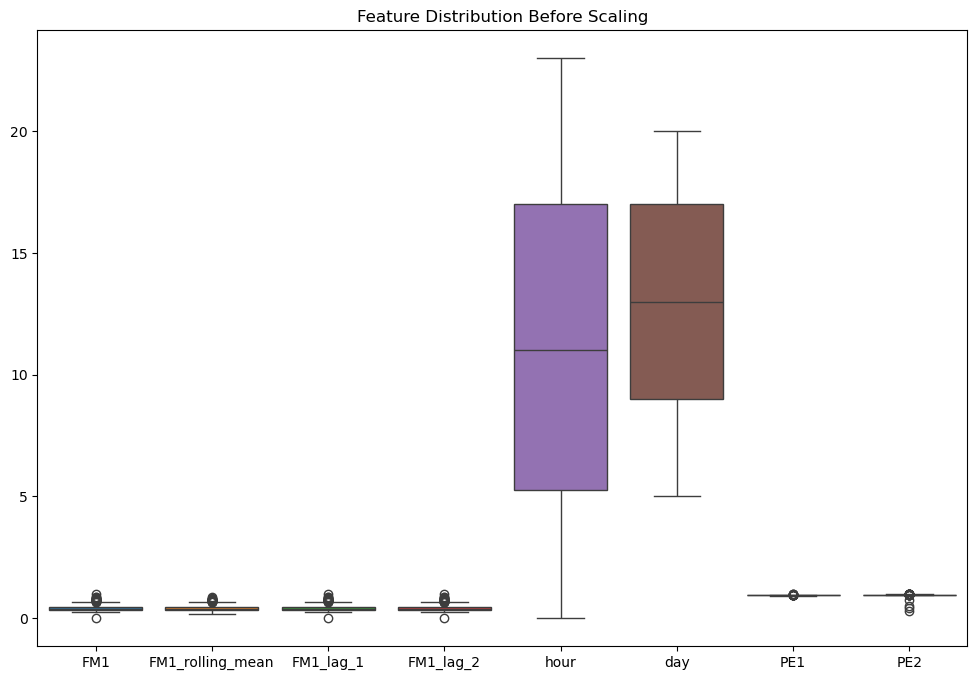

In [141]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=X)
plt.title('Feature Distribution Before Scaling')
plt.show()

# Standardize the features

In [144]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Visualization: Feature Distribution After Scaling

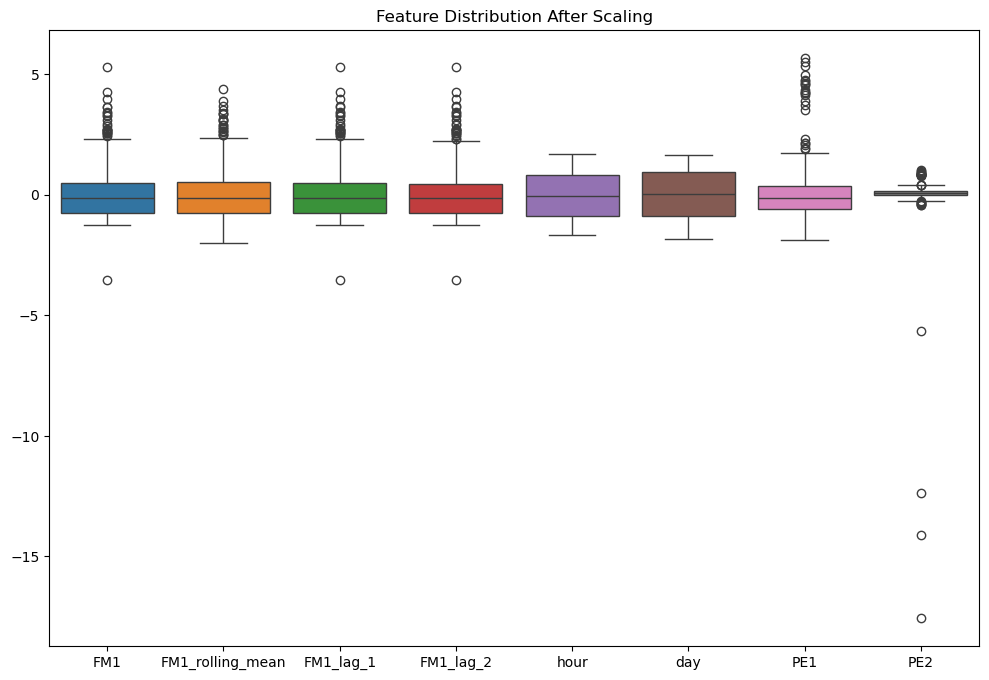

In [147]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=pd.DataFrame(X_scaled, columns=X.columns))
plt.title('Feature Distribution After Scaling')
plt.show()

# Apply SMOTE to balance the dataset

In [150]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [152]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Initialize the Random Forest model

In [42]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Cross-validation with Stratified K-Fold

In [45]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=skf, scoring='accuracy')

# Visualization: Cross-Validation Accuracy Scores

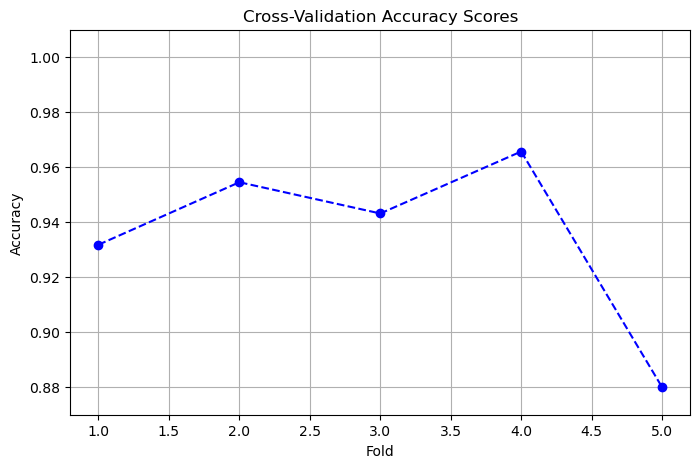

Cross-Validation Accuracy Scores: [0.93181818 0.95454545 0.94318182 0.96571429 0.88      ]
Mean CV Accuracy: 0.935051948051948


In [48]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='--', color='b')
plt.title('Cross-Validation Accuracy Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([min(cv_scores) - 0.01, 1.01])
plt.grid(True)
plt.show()

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Fit the Random Forest model on the training data

In [51]:
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the Model

In [54]:
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Test Set Accuracy: 0.9318181818181818
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93       110
           1       0.94      0.93      0.93       110

    accuracy                           0.93       220
   macro avg       0.93      0.93      0.93       220
weighted avg       0.93      0.93      0.93       220



# Confusion Matrix Visualization

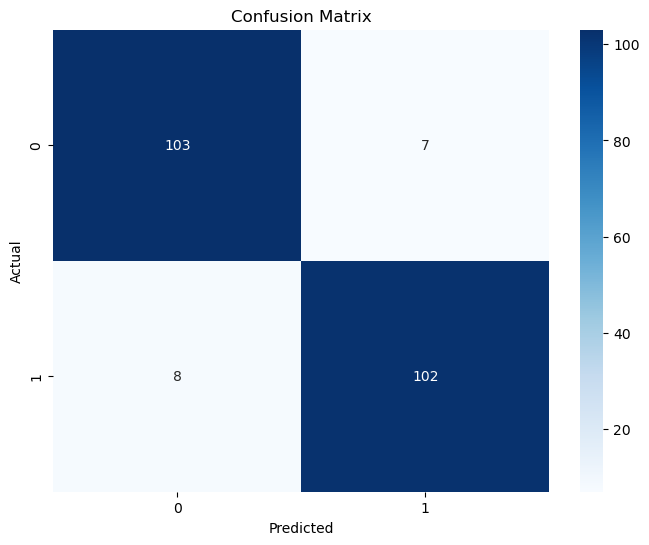

In [57]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance Visualization

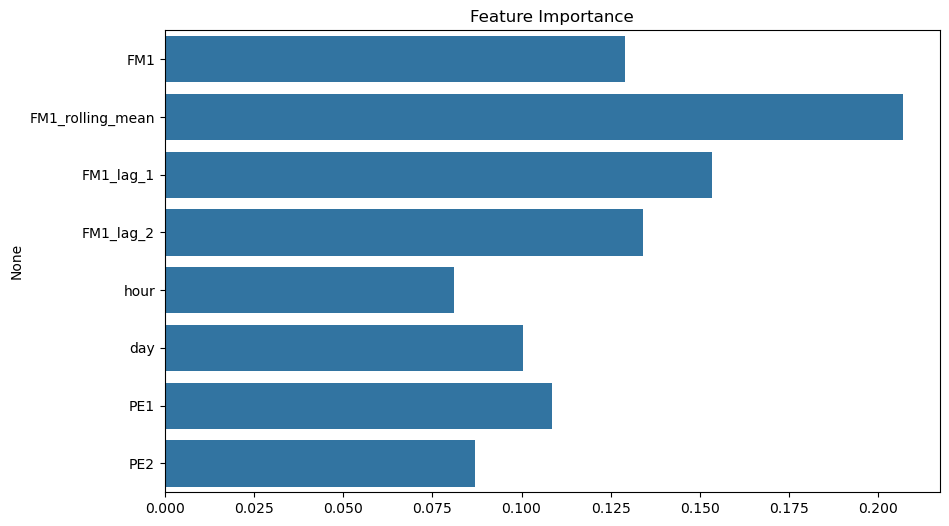

In [60]:
feature_importances = rf_model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features)
plt.title('Feature Importance')
plt.show()

# Precision-Recall Curve Visualization

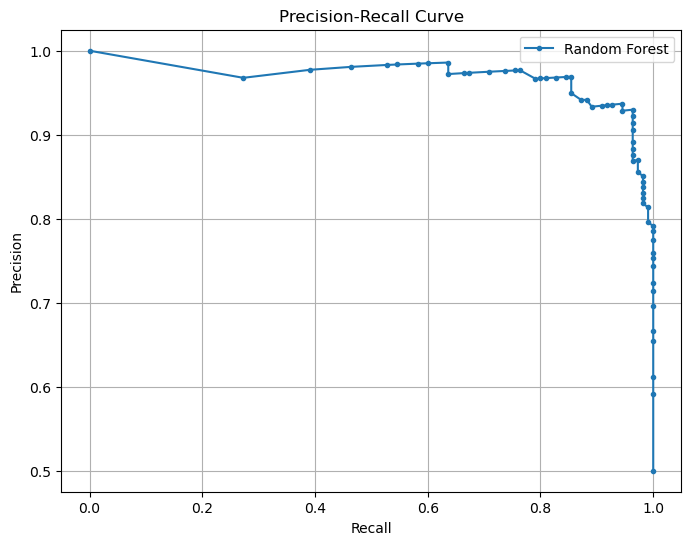

In [63]:
y_probs = rf_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.show()

# ROC Curve Visualization

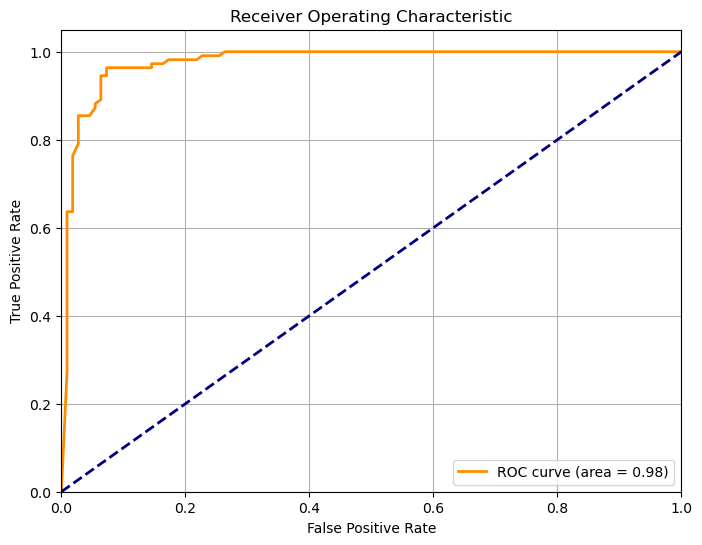

In [66]:
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# For SVM Model
## Initialize the SVM model

In [96]:
svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)


# Cross-validation with Stratified K-Fold

In [99]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=skf, scoring='accuracy')

# Visualization: Cross-Validation Accuracy Scores

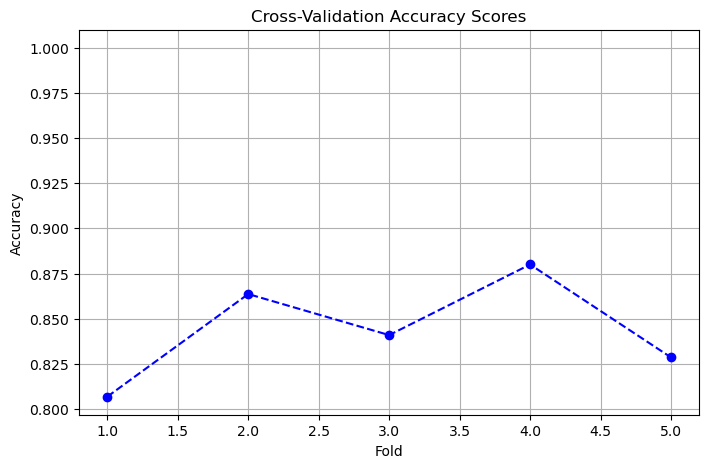

Cross-Validation Accuracy Scores: [0.80681818 0.86363636 0.84090909 0.88       0.82857143]
Mean CV Accuracy: 0.843987012987013


In [102]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='--', color='b')
plt.title('Cross-Validation Accuracy Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([min(cv_scores) - 0.01, 1.01])
plt.grid(True)
plt.show()

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Fit the SVM model on the training data

In [108]:
svm_model.fit(X_train, y_train)
# Predict on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the Model

In [ ]:
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization

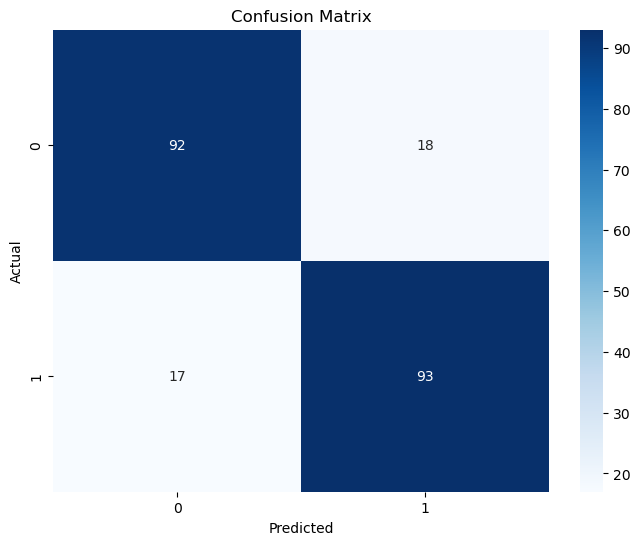

In [111]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Precision-Recall Curve Visualization

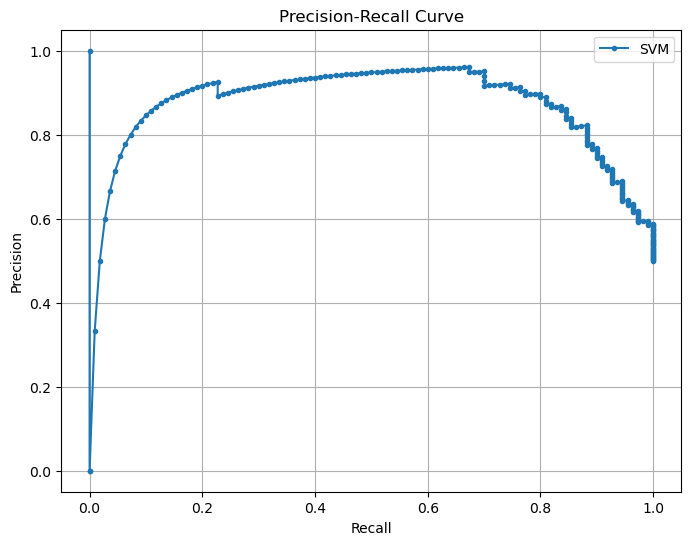

In [114]:
y_probs = svm_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='SVM')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.show()

# ROC Curve Visualization

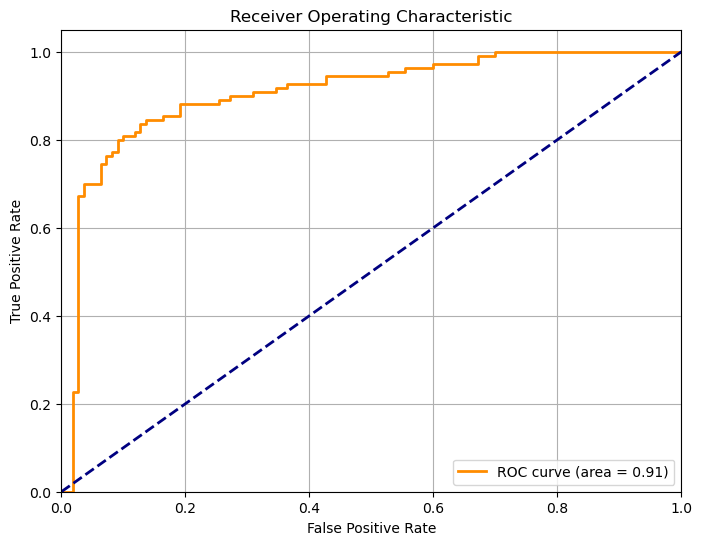

In [116]:
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# For K-NN Model
## Initialize the k-NN model

In [155]:
knn_model = KNeighborsClassifier(n_neighbors=5)

#  Cross-validation with Stratified K-Fold

In [159]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=skf, scoring='accuracy')

# Visualization: Cross-Validation Accuracy Scores

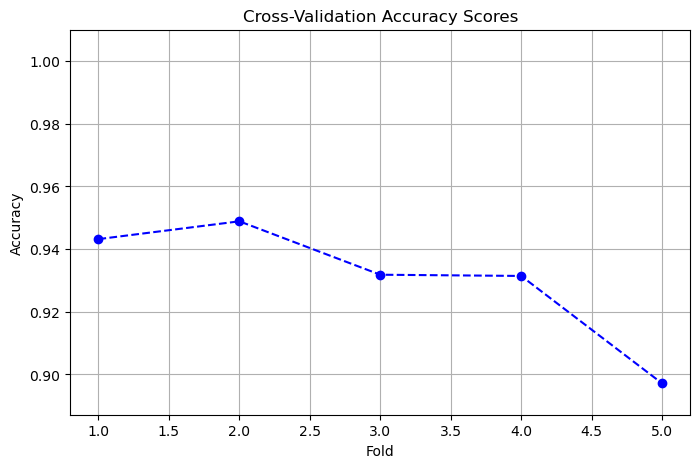

Cross-Validation Accuracy Scores: [0.94318182 0.94886364 0.93181818 0.93142857 0.89714286]
Mean CV Accuracy: 0.930487012987013


In [162]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='--', color='b')
plt.title('Cross-Validation Accuracy Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([min(cv_scores) - 0.01, 1.01])
plt.grid(True)
plt.show()

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Fit the k-NN model on the training data
knn_model.fit(X_train, y_train)

# Predict on the test set
y_pred = knn_model.predict(X_test)

# Evaluate the model

In [165]:
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Test Set Accuracy: 0.9454545454545454
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94       110
           1       0.91      0.99      0.95       110

    accuracy                           0.95       220
   macro avg       0.95      0.95      0.95       220
weighted avg       0.95      0.95      0.95       220



# Confusion Matrix

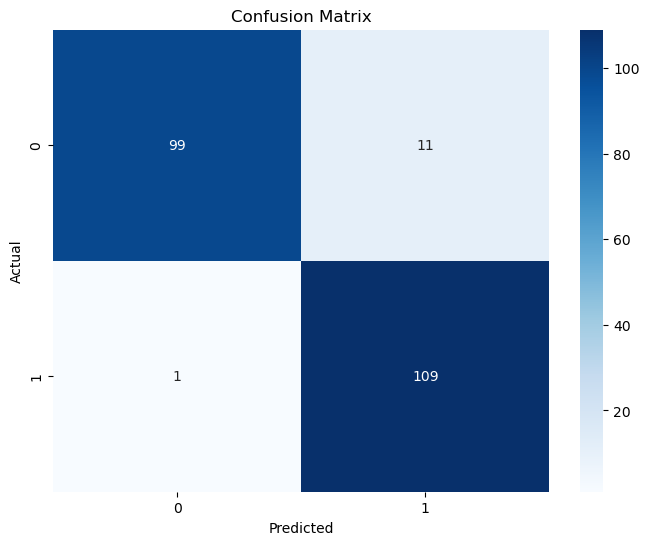

In [168]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Precision-Recall Curve Visualization

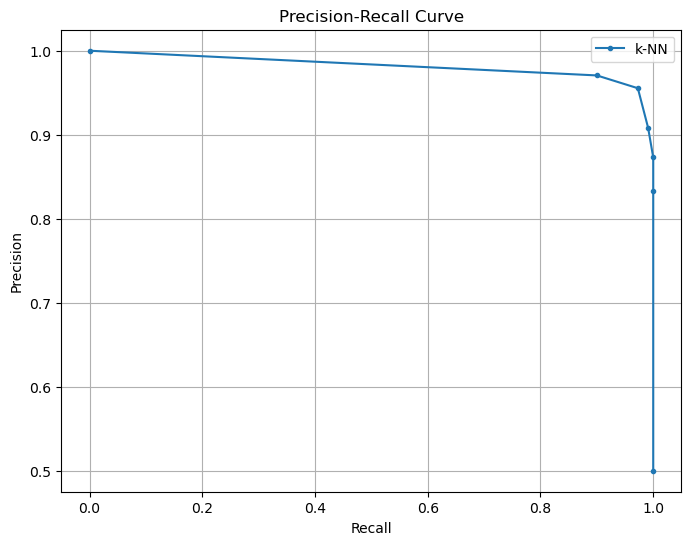

In [171]:
y_probs = knn_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='k-NN')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.show()

# ROC Curve visualization 

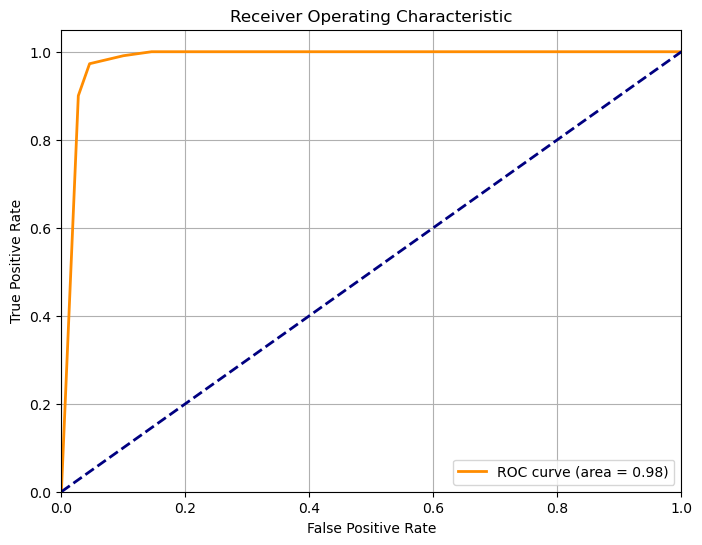

In [174]:
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()